In [ ]:
# default_exp gbe.sst.scoring

# SST - Scoring

<div>
    <p style="float: left;"><img src="images/fruit_game.png" alt="Drawing" style="width: 200px; border-right:10px solid white"/> 
    <p>During the SST, fruits fall from the top of the screen and participants collect them by tapping on the grey circles (go-trials).  In 12 (37.5%) of the 32 trials, the fruit turns brown and participants are not supposed to collect them (stop-trials).</p><p>For go-trials, the task outputs a reaction time (RT).  For stop trials, the task outputs the delay after which the fruit turned brown (stop-signal delay; SSD).  The task also outputs the accuracy of each trial (whether the participants succesfully initiated or stopped their reaction).  From these observed variables the latent stop-signal reaction time (SSRT) can be calculated.</p>
</div>


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

In [ ]:
#export
from trr265.gbe.sst.data_provider import SSTDataProvider
import pandas as pd
import numpy as np
from scipy import stats
import biuR.wrapper

## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")

> Warning: We are not filtering out any data (e.g. sessions that failed the independence assumption (see `SSTDataProvider`).

## Example data

In [ ]:
example = df.query("gbe_index=='m163_002'").reset_index(drop = True)
example.index += 1
example[['participant','session_number','trial_number','is_stop','ssd','rt','accuracy','omission','comission','premature']]

,participant,session_number,trial_number,is_stop,ssd,rt,accuracy,omission,comission,premature
1,m163,2.0,1,0.0,NaN,787.0,1,0.0,0.0,0.0
2,m163,2.0,2,1.0,300.0,795.0,0,0.0,1.0,0.0
3,m163,2.0,3,0.0,NaN,732.0,1,0.0,0.0,0.0
4,m163,2.0,4,0.0,NaN,802.0,0,1.0,0.0,0.0
5,m163,2.0,5,1.0,250.0,710.0,0,0.0,1.0,0.0
6,m163,2.0,6,0.0,NaN,946.0,0,1.0,0.0,0.0
7,m163,2.0,7,0.0,NaN,622.0,1,0.0,0.0,0.0
8,m163,2.0,8,0.0,NaN,896.0,0,1.0,0.0,0.0
9,m163,2.0,9,0.0,NaN,628.0,1,0.0,0.0,0.0
10,m163,2.0,10,0.0,NaN,652.0,1,0.0,0.0,0.0


## Aggregation methods

### The gold standard: Integration methods
Integration methods are non-parametric methods to estimate SSRTs.  In these methods "the point at which the stop process finishes is estimated by ‘integrating’ the RT distribution and finding the point at which the integral equals p(respond|signal)." (Verbruggen et al., 2019)

<img src="images/horse_race.png" alt="Drawing" width="500px" style="border-right:10px solid white"/>
<p></p>
<p>All integration methods calculate the mean SSD from all stop trials and find the reaction time associated with p(respond|signal):</p>

In [ ]:
#export
def integration_methods_wrapper(find_nth_rt):
    def wrapper(df):
        # Calculating the average SSD
        signal = df.query("is_stop==1")
        mean_ssd = signal.ssd.mean()
        # The nth RT is calculated differently by the different integration methods
        nth_rt = find_nth_rt(df) # <- This function is defined by different integration methods (see below).
        # Calculating ssrt
        ssrt = nth_rt - mean_ssd
        return ssrt
    return wrapper

#export
def verbruggen_quantile(rts, p_resp):
    R = biuR.wrapper.R()
    nth = R("""
    nth <- round(quantile(rts, probs = p_resp, type = 6))
    """, push = dict(rts = rts, p_resp = p_resp))
    return nth[0]

In [ ]:
#def verbruggen_quantile(rts, p_resp):
#    %R nth <- round(quantile(rts, probs = p_resp, type = 6)) -i rts -i p_resp -o nth
#    return nth[0]

### Integration with replacement of go omissions (ToDo)
This method calculates p(respond|signal) based on the unadjusted probability of responding in stop trials.  Next, it replaces RTs on omission trials with the maximum valid RT. Finally, it finds the nth RT based on all go trials with valid responses (i.e., premature trials and omissions are excluded).

### Integration with exclusion of go omissions
This method calculates p(respond|signal) based on the unadjusted probability of responding in stop trials.  Next, it finds the nth RT based on all go trials with valid responses (i.e., premature trials and omissions are excluded).  This method is used by Smittenaar et al. (2015).

In [ ]:
#export
@integration_methods_wrapper
def integration_without_replacement(df):
    # p_stop is calculated 
    p_resp = df.query("is_stop==1").responded.mean() # p_resp matches
    # We include all valid go RTs (this means we exclude premature and late responses)
    no_signal_resp_rts = df.query("is_stop==0 and accuracy==1").rt
    nth_rt = verbruggen_quantile(no_signal_resp_rts, p_resp)
    return nth_rt

def get_integration_without_replacement_ssrts(df):
    return df.groupby('gbe_index').apply(integration_without_replacement).to_frame(name = "ssrt_integration_without_replacement")

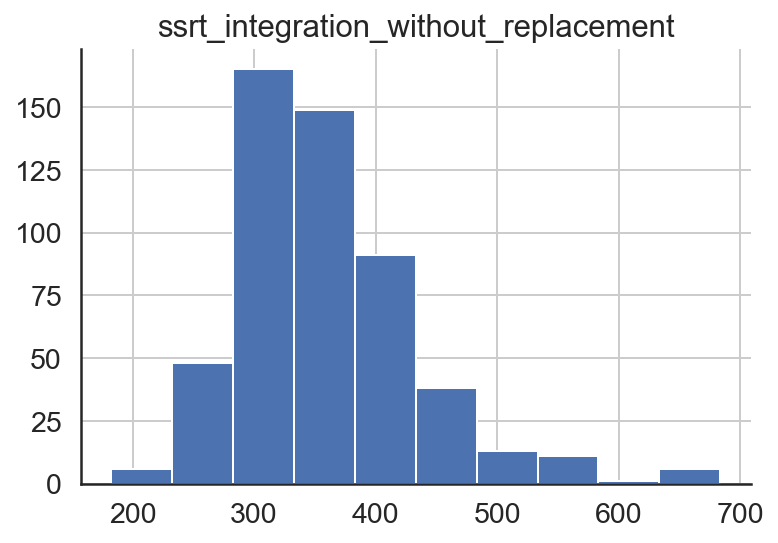

In [ ]:
integration_without_replacement_ssrts = get_integration_without_replacement_ssrts(df)
integration_without_replacement_ssrts.hist()
sns.despine()

### Integration method with adjustment of p(respond|signal) (ToDo)

### Parametric (bayesian) methods (ToDo)
Parametric estimations of SSRTs can be used when the indepndence assumption is not met (e.g., Matzke et al., 2018, 2019).  However, these might require more trials (Note: Perhaps we could use priors based on participant data to compensate for this).

Question: I'm not sure how to interpret this plot: Is "Session" (i.e., "Items"), the systematic effect of session?

## Simplified method for trial level analysis: Mean method

The mean method is generally not recommended as it relies on an p(respond|signal) being exactly 50%; It's also highly biased by the tail of the RT-distribution.  On the other, the mean method might lend itself well to trial-level analyses.  Given that in our data p(respond|signal) is relatively close to 50%, we might therefore still consider the mean method.

In [ ]:
#export
def mean_method_ssrt(df):
    return df.query("is_stop==0").rt.mean() - df.ssd.mean()

def get_mean_method_ssrts(df):
    return df.groupby('gbe_index').apply(mean_method_ssrt).to_frame(name = "ssrt_mean_method")

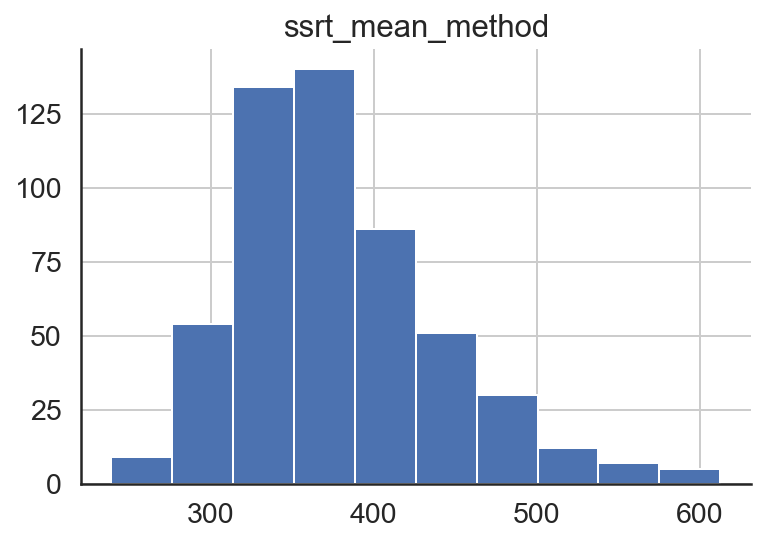

In [ ]:
mean_ssrts = get_mean_method_ssrts(df)
mean_ssrts.hist()
sns.despine()

## Trial level analyses

### Modelling sessions separately

In [ ]:
#export
def get_ssrt_predicted_sep_r(df):
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=lmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = lmer(ssd_rt ~ 1 + (1 + is_stop | participant), data=df, na.action = na.exclude)
    # Extracting predicted values
    ggpredict(m, terms=c("is_stop","participant"), type="re",ci.lvl = NA)
    """,push=dict(df=df))
    m = R("""m""")
    return p, m

def get_ssrt_sep(df):   
    # Creating combined variable for ssd and rt
    df['ssd_rt'] = (df['ssd']).fillna((df.query("is_stop==0").rt))
    dfs = []
    # Looping through sessions
    for session in [2,1]:
        # Extracting data for specific session and trial type
        _df = df.query('(session_number==@session)')
        # Predicting scores
        predicted, m = get_ssrt_predicted_sep_r(_df)
        predicted.columns = ['is_stop','predicted','participant']
        predicted = predicted.set_index(['participant','is_stop']).unstack()
        predicted['ssrt_predicted'] = predicted[('predicted',0.0)] - predicted[('predicted',1.0)]
        predicted = predicted[('ssrt_predicted',  '')].to_frame(name="ssrt_predicted_sep").reset_index()
        # Labeling variables
        predicted['session'] = session
        predicted['gbe_index'] = predicted.participant.astype(str) + '_%03d'%session
        predicted = predicted.set_index('gbe_index')['ssrt_predicted_sep'].to_frame()
# Combining everything into one dataframe
        dfs.append(predicted)
    perc_predicted_sep = pd.concat(dfs)     
    return perc_predicted_sep, m

In [ ]:
ssrt_predicted_sep = get_ssrt_sep(df)

R[write to console]: Lade nötiges Paket: lme4

R[write to console]: Lade nötiges Paket: Matrix

R[write to console]: 
Attache Paket: ‘lmerTest’


R[write to console]: Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer


R[write to console]: Das folgende Objekt ist maskiert ‘package:stats’:

    step




#### Distribution

array([[<AxesSubplot:title={'center':'ssrt_predicted_sep'}>]],
      dtype=object)

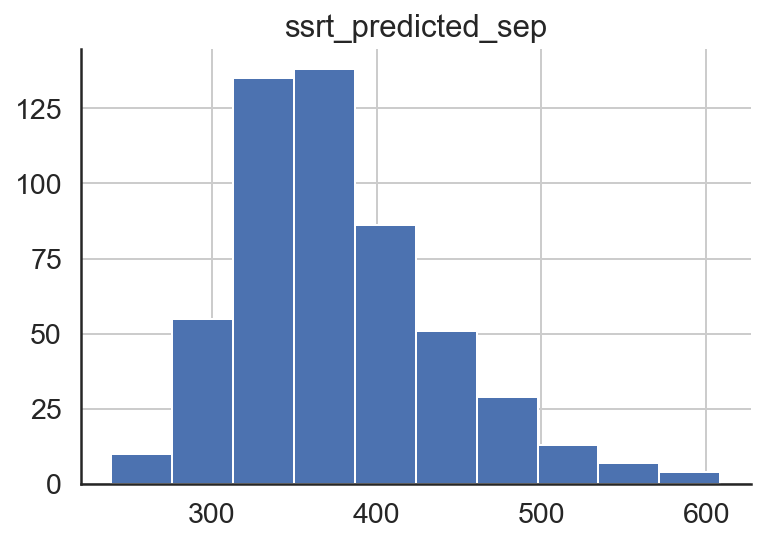

In [ ]:
ssrt_predicted_sep[0].hist()

#### Correlation with integration method

<AxesSubplot:xlabel='ssrt_mean_method', ylabel='ssrt_predicted_sep'>

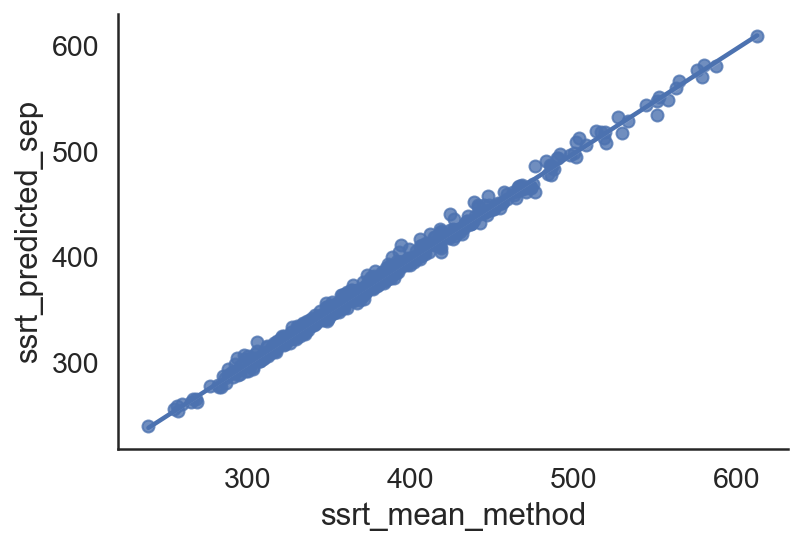

In [ ]:
sns.regplot(x = 'ssrt_mean_method', y = 'ssrt_predicted_sep', data = pd.concat([mean_ssrts, ssrt_predicted_sep[0]], axis = 1))

<AxesSubplot:xlabel='ssrt_integration_without_replacement', ylabel='ssrt_predicted_sep'>

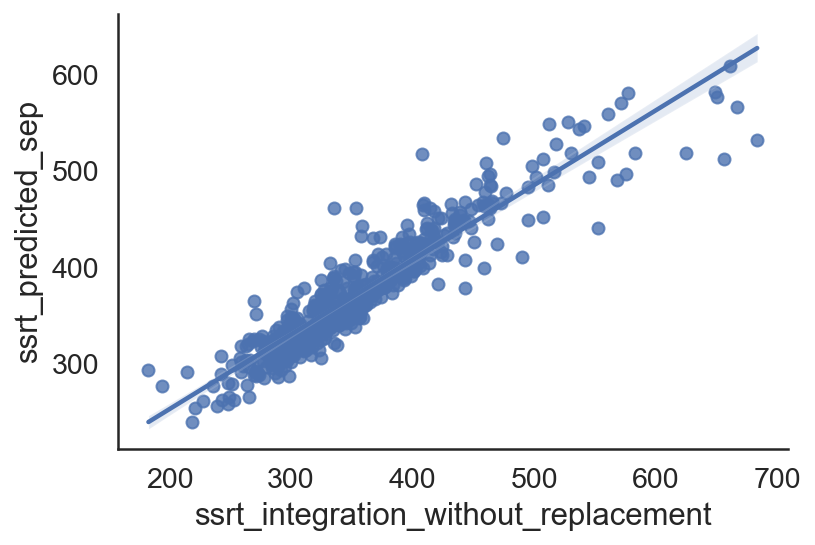

In [ ]:
sns.regplot(x = 'ssrt_integration_without_replacement', y = 'ssrt_predicted_sep', data = pd.concat([integration_without_replacement_ssrts, ssrt_predicted_sep[0]], axis = 1))

In [ ]:
from scipy.stats import pearsonr
_df = pd.concat([integration_without_replacement_ssrts, ssrt_predicted_sep[0]], axis = 1)
pearsonr(_df['ssrt_integration_without_replacement'],_df['ssrt_predicted_sep'])

(0.9321344556690161, 3.3360732060516906e-234)

### Modelling sessions jointly

In [ ]:
#export
def get_ssrt_predicted_joint_r(df):    
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=lmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = lmer(ssd_rt ~ 1 + (1 | is_stop / participant / session), data=df, na.action = na.exclude)
    # Extracting predicted values
    ggpredict(m, terms=c("participant", "is_stop", "session"), type="re",ci.lvl = NA)
    """,push=dict(df=df))
    
    m = R("""m""")
    return p, m

def get_ssrt_predicted_joint(df):
    df['ssd_rt'] = (df['ssd']).fillna((df.query("is_stop==0").rt))
    df['session'] = df.session_number.astype(str) # making session a factor 
    # Predicting scores
    predicted, m = get_ssrt_predicted_joint_r(df)
    predicted.columns = ['participant','predicted','is_stop','session']
    predicted = predicted.set_index(['participant','session','is_stop']).unstack()
    predicted['ssrt_predicted_joint'] = predicted[('predicted','0')] - predicted[('predicted','1')]
    predicted = predicted[('ssrt_predicted_joint','')].to_frame(name="ssrt_predicted_joint").reset_index()
    predicted['gbe_index'] = predicted.participant.astype(str) + predicted.session.apply(lambda x: '_%03d'%int(float(x))).astype(str)
    predicted = predicted.set_index('gbe_index')['ssrt_predicted_joint'].to_frame()
    # Removing sessions that were not in initial dataframe
    predicted = predicted.loc[df.gbe_index.unique()]
    return predicted, m

#### Distribution

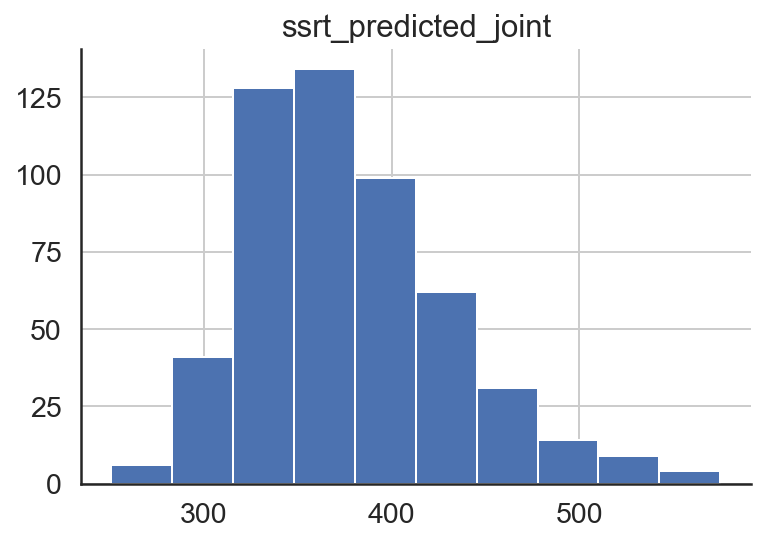

In [ ]:
ssrt_predicted_joint, m = get_ssrt_predicted_joint(df)
ssrt_predicted_joint.hist()
sns.despine()

#### Correlation with integration method

(180.0, 600.0)

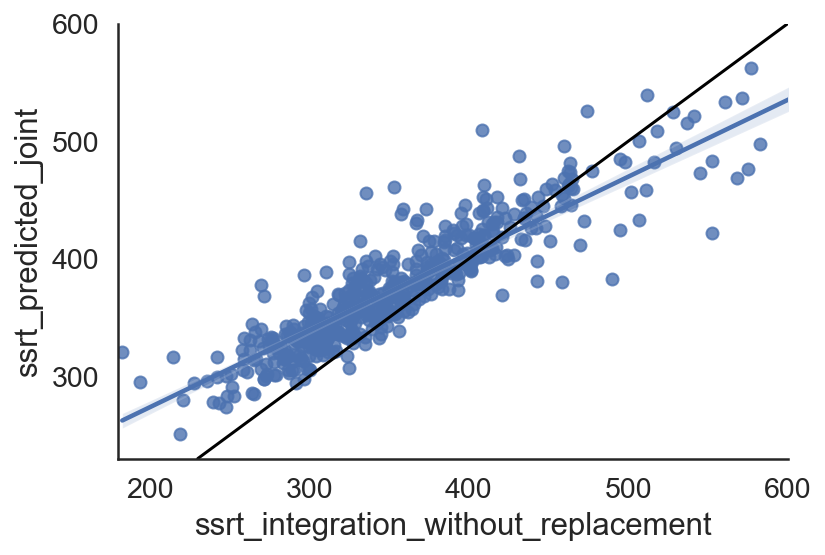

In [ ]:
ax = sns.regplot(x = 'ssrt_integration_without_replacement', y = 'ssrt_predicted_joint', data = pd.concat([integration_without_replacement_ssrts, ssrt_predicted_joint], axis = 1))
ax.axline((1, 1), slope=1, color = 'black')
ax.set_ylim(230,600)
ax.set_xlim(180,600)

#### Correlation with mean method

(200.0, 600.0)

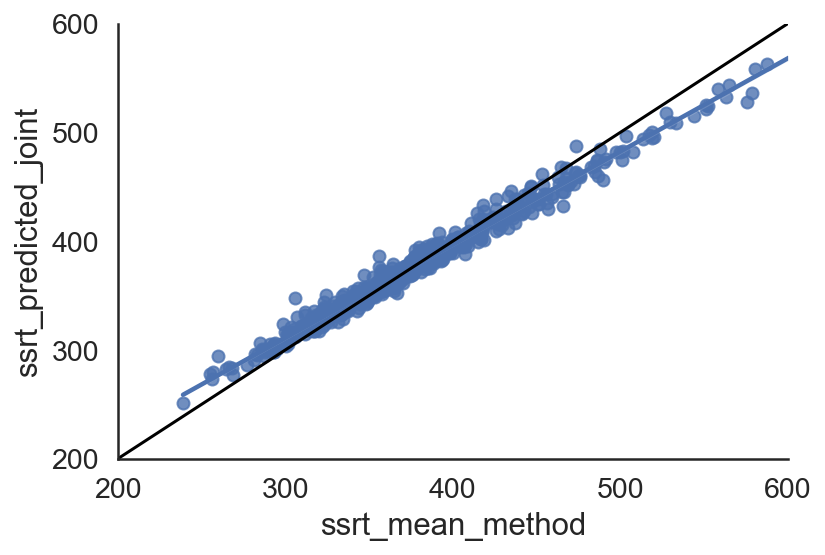

In [ ]:
ax = sns.regplot(x = 'ssrt_mean_method', y = 'ssrt_predicted_joint', data = pd.concat([mean_ssrts, ssrt_predicted_joint], axis = 1))
ax.axline((1, 1), slope=1, color = 'black')
ax.set_ylim(200,600)
ax.set_xlim(200,600)

## Correlations between different scores

In [ ]:
def correl(df):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = stats.pearsonr(df[x], df[y])
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .01, bonferroni = False, size = (11,9), show_correl = True):

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data)
    sig = (df_p < alpha).replace({True:"*",False:""})
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr.applymap(lambda x: '%.3f'%x),fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    #p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()

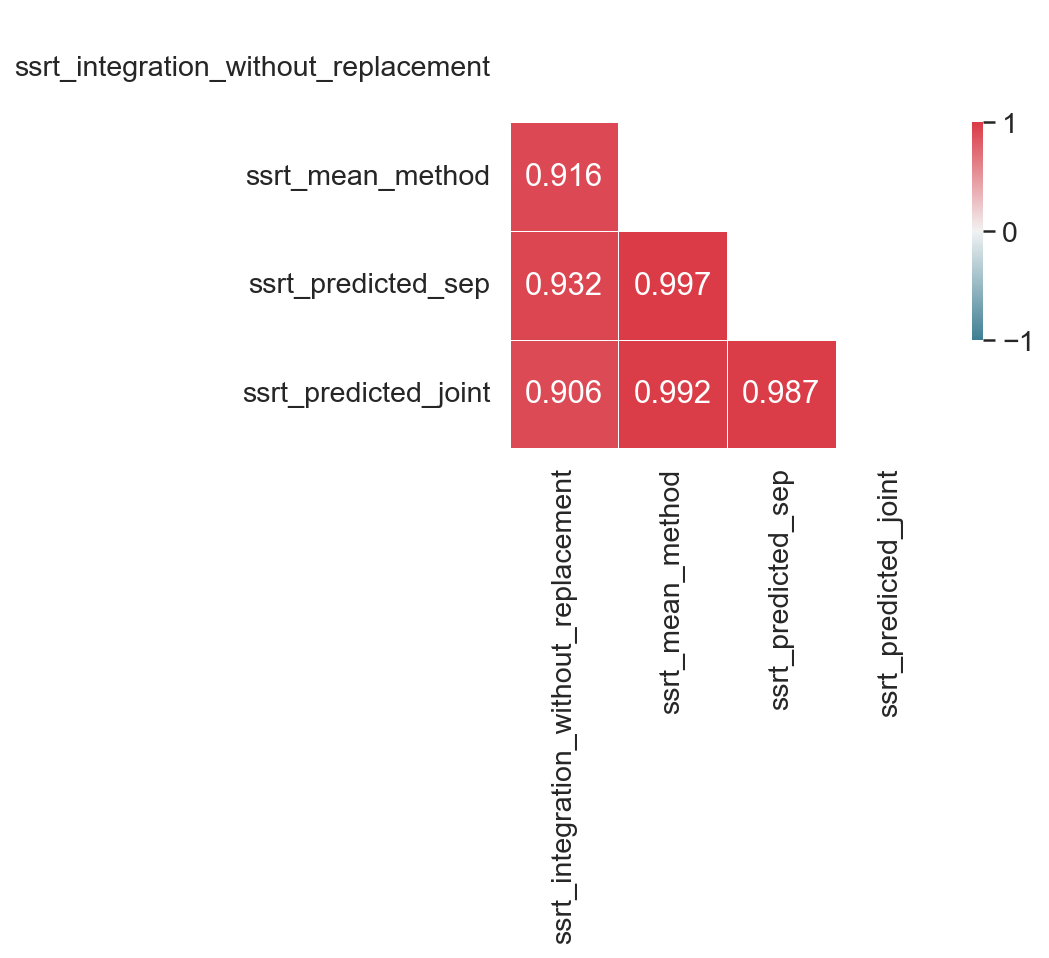

In [ ]:
def show_correlations():
    df = pd.concat([integration_without_replacement_ssrts, mean_ssrts, ssrt_predicted_sep[0], ssrt_predicted_joint], axis = 1)
    correlation_matrix(df, size = (5,4))
show_correlations()